# Descriptive Data Analysis of Insurance dataset

We will be using Mobiliar insurance dataset. We have to select features we are going to consider for our analysis as well as devise a plan to aggregate data on zip-code level.

First of all, we are going to read the dataset and visualize its features:

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [2]:
DATA_DIR = './data/'

In [3]:
zurich_df = pd.read_pickle(DATA_DIR + 'zurich_insurance.pkl')

In [4]:
# look at features available & data type
zurich_df.columns

Index(['JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang',
       'Nation', 'ZIP', 'Children_0-26', 'Car1_Canton', 'Car1_Brand',
       'Car1_Class', 'Car1_Price', 'Car1_1Imtr', 'Car1_ccm', 'Car1_ClaimsCt5Y',
       'Car1_ClaimsSum5Y', 'Car2_Canton', 'Car2_Brand', 'Car2_Class',
       'Car2_Price', 'Car2_1Imtr', 'Car2_ccm', 'Car2_ClaimsCt5Y',
       'Car2_ClaimsSum5Y', 'Car_Premium', 'HH_Zip', 'HH_Ins_Sum',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'Build_Ins_Sum',
       'HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y', 'HH_and_Bld_Prem.', 'BFS'],
      dtype='object')

We will only keep number of cars, total car price and total premium with regard to cars and drop other values

In [5]:
# person's ownership of cars: 
# The information we want: # car, total car price, total car premium
# aggregate # car
zurich_df['num_cars'] = (zurich_df['Car1_Price'] > 0).astype(int) + (zurich_df['Car2_Price'] > 0).astype(int)

# aggregate total car price
zurich_df['total_car_spending'] = zurich_df['Car1_Price'] + zurich_df['Car2_Price']

zurich_df = zurich_df.drop(['Car1_Canton', 'Car1_Brand','Car1_Class', 'Car1_Price', \
                            'Car1_1Imtr', 'Car1_ccm', 'Car1_ClaimsCt5Y','Car1_ClaimsSum5Y', \
                            'Car2_Canton', 'Car2_Brand', 'Car2_Class', 'Car2_Price',\
                            'Car2_1Imtr', 'Car2_ccm', 'Car2_ClaimsCt5Y', 'Car2_ClaimsSum5Y'], axis=1)

zurich_df.columns

Index(['JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang',
       'Nation', 'ZIP', 'Children_0-26', 'Car_Premium', 'HH_Zip', 'HH_Ins_Sum',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'Build_Ins_Sum',
       'HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y', 'HH_and_Bld_Prem.', 'BFS',
       'num_cars', 'total_car_spending'],
      dtype='object')

We will also keep location, number of rooms and standard of furniture (categorical variable) as well as add a new feature that will represent sum of premium on house/building. Other features regarding ownership properties will be dropped.

In [6]:
# person's ownership of properties: 
# keep: location of house & building, # rooms, standard of furniture, sum(premium on hourse/building)
zurich_df['property_premium'] = zurich_df['HH_Ins_Sum'].astype(int) + zurich_df['Build_Ins_Sum'].astype(int)
zurich_df = zurich_df.drop(['HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y', 'HH_and_Bld_Prem.', 'BFS', 'HH_Ins_Sum', 'Build_Ins_Sum'], axis=1)
zurich_df.columns

Index(['JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang',
       'Nation', 'ZIP', 'Children_0-26', 'Car_Premium', 'HH_Zip',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'num_cars', 'total_car_spending',
       'property_premium'],
      dtype='object')

Since we have many different nationalities, we will group them into two categories: 1) Swiss and 2) non Swiss. We might consider more fine grained grouping if needed during analysis

In [7]:
# change Nation to Swiss vs Non-Swiss
zurich_df['Nation'] = zurich_df['Nation'].apply(lambda x : x.strip())
zurich_df['is_swiss'] = (zurich_df['Nation'] == 'CH').astype(str)

Then we will identify categorical variables, as well as derive new features such as age (using current and birth year), as well as well as adjust types for some of the features.

In [8]:
# convert 'JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang', 'Nation' to categorical data
for col in ['JobState', 'Job', 'Civil', 'Gender', 'Own/Rent', 'Lang', 'Nation']:
    zurich_df[col] = zurich_df[col].astype('category')

In [9]:
# calculate age of insurer, also convert the type of standard of furniture & # rooms
zurich_df['Age'] = 2018 - zurich_df['YearOfBirth']
zurich_df['Stand_of_furn'] = zurich_df['Stand_of_furn'].apply(lambda x : '0' if x.strip() == '' else x.strip()).astype(int)
zurich_df['Rooms'] = zurich_df['Rooms'].apply(lambda x : '0' if x.strip() == '' or x.strip() == 'NA' else x.strip()).astype(float)

### Aggregate the data of the entries per area (can be one zip code area or Zurich as a whole)
###### For categorical data, we calculate the percentage of each category
###### For numerical data, we calculate the average

In [10]:
def aggregate_categorical_map(df):
    '''
    given a dataframe, aggregate the categorical data that we want to study
    return a map of the form:
    category -> {subcategory1: percentage.ect}
    '''
    aggregation = {}
    total = df.shape[0]
    for col in ['JobState', 'Civil', 'Gender', 'Own/Rent', 'Lang', 'is_swiss']:
        aggregation[col] = {}
        for val in df[col].unique():
            key = val.strip()
            if key == '': key = 'Unknown'
            key = '%' + col + '_' + key
            aggregation[col][key] = [100*len(df.loc[df[col] == val])/total]
    return aggregation

In [11]:
def aggregate_numerical_df(df, index):
    '''
    given a dataframe
    return a dataframe where the each column has the average value of that column in the input dataframe
    '''
    num_aggregation = {}
    for col in ['Children_0-26', 'Car_Premium', 'num_cars', 'total_car_spending', 'property_premium', 'Age', 'Stand_of_furn', 'Rooms']:
        avg = zurich_df[col].mean()
        num_aggregation['Avg_'+col] = [avg]    
    return pd.DataFrame(num_aggregation, index=index)

In [12]:
# visualize the categorical aggregation data for Zurich
agg = aggregate_categorical_map(zurich_df)
for category in agg:
    data_pd = pd.DataFrame.from_dict(agg[category])
    # visualize the dataframe

In [13]:
# present the numerical aggregation data for Zurich
num_agg_df = aggregate_numerical_df(zurich_df, ['Zurich'])
num_agg_df

,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
Zurich,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757


### Group the on the zip code level and study the data for each zip code area

In [14]:
zip_group = zurich_df.groupby('ZIP')
# zipcode -> dataframe
zip_group_dic = {zip_code: df for (zip_code, df) in zip_group}

# all zipcodes
zip_group_dic.keys()

dict_keys(['8001', '8002', '8003', '8004', '8005', '8006', '8008', '8021', '8022', '8024', '8027', '8031', '8032', '8034', '8036', '8037', '8038', '8040', '8041', '8042', '8044', '8045', '8046', '8047', '8048', '8049', '8050', '8051', '8052', '8053', '8055', '8057', '8064', '8098'])

In [15]:
# number of data in each zip code, use to_dict so it's displayed horizontally to save space
data_count = zip_group.size()
print(data_count.to_dict())

{'8001': 691, '8002': 1093, '8003': 2499, '8004': 3326, '8005': 2089, '8006': 2370, '8008': 1960, '8021': 6, '8022': 4, '8024': 10, '8027': 6, '8031': 5, '8032': 2226, '8034': 2, '8036': 6, '8037': 2159, '8038': 2043, '8040': 4, '8041': 701, '8042': 2, '8044': 1299, '8045': 1197, '8046': 2471, '8047': 2418, '8048': 3038, '8049': 2853, '8050': 2751, '8051': 1924, '8052': 1918, '8053': 1274, '8055': 2297, '8057': 2327, '8064': 267, '8098': 6}


In [16]:
# if the zip code area has < 250 entries, we ignore the region
data_count = data_count.to_frame(name='Count')
zip_skip = data_count.loc[data_count['Count'] < 250].index

### Visualize distributions for the entire city of Zurich

In [17]:
df_dic = zip_group_dic
df_dic['Zurich'] = zurich_df
zurich_df.head()

,JobState,Job,Civil,YearOfBirth,Gender,Own/Rent,Lang,Nation,ZIP,Children_0-26,Car_Premium,HH_Zip,Stand_of_furn,Rooms,Build_Zip,num_cars,total_car_spending,property_premium,is_swiss,Age
49,,0000 ...,,1946,,E,D,,8004,0,0.0,8004,0,0.0,8004,0,0,703000,False,72
73,Rentner,0000 ...,Verwitwet,1935,W,M,D,CH,8032,0,0.0,8032,2,3.5,0,0,0,80000,True,83
178,Angestellt,0000 ...,Verheiratet,1942,M,M,D,CH,8048,0,0.0,8048,0,0.0,0,0,0,85000,True,76
398,Rentner,0000 ...,Verheiratet,1938,M,M,D,SV,8038,0,0.0,8038,0,0.0,0,0,0,95000,False,80
503,Angestellt,0000 ...,Ledig,1961,W,M,D,CH,8037,0,0.0,8037,1,2.0,0,0,0,33000,True,57


In [18]:
def plot_numerical(df_to_plot, ncols):
    '''
    This function plots the distribution of the data given in the input using histograms.
    
    Parameters:
    df_to_plot = dataframe of data_to_plot, all columns are plotted
    '''
    nrows= int(1 + df_to_plot.shape[1] // (ncols+0.01))
    
    f, axs = plt.subplots(nrows,ncols,figsize=(16, nrows*4))
    
    for k, col in enumerate(df_to_plot.columns):
        axs[k].hist(df_to_plot[col],bins=20)
        axs[k].grid(color='k', linestyle='-', linewidth=0.2)
        axs[k].set_title(col)

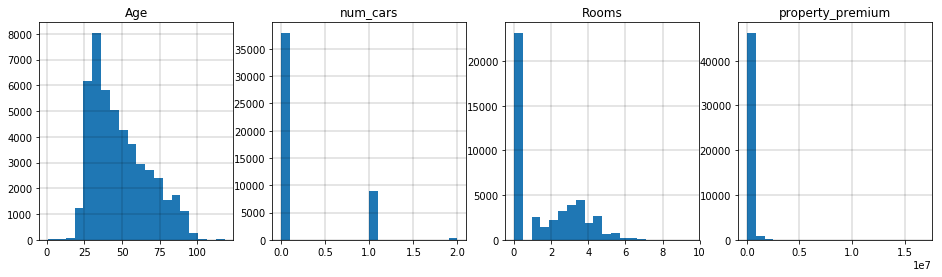

In [19]:
# plotting some of the numerical data
plot_numerical(zurich_df[['Age','num_cars','Rooms','property_premium']],4)

### Aggregate the data for each zip code

##### aggregate numerical data for each zip code area

In [20]:
num_aggregate_all = pd.DataFrame()
for area in df_dic:
    num_aggregate_all = pd.concat([num_aggregate_all, aggregate_numerical_df(df_dic[area], [area])])
num_aggregate_all.head(3)

,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
8001,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757
8002,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757
8003,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757


##### aggregate categorical data for each zip code area

In [21]:
def get_all_categorical_aggregation(df_dic):
    '''
    input: {area -> dataframe of the info the area}
    return: {category -> df of aggregation data of all area (row: zip; col: data)}
    '''
    # category -> df of aggregation data of all area (row: zip; col: data)
    area_agg_by_category = {}
    for area in df_dic:
        if area in zip_skip:
            continue

        aggregation = aggregate_categorical_map(df_dic[area])
        for category in aggregation:
            df = pd.DataFrame.from_dict(aggregation[category])
            df.index = [area+'_']
            if category in area_agg_by_category.keys():
                area_agg_by_category[category] = pd.concat([area_agg_by_category[category], df])
            else:
                area_agg_by_category[category] = df
    for key in area_agg_by_category:
        area_agg_by_category[key] = area_agg_by_category[key].fillna(0.0)
    return area_agg_by_category

In [25]:
area_agg_by_category = get_all_categorical_aggregation(df_dic)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### Visualize the aggregated categorical data for each area

In [26]:
def df_to_vis_string(df, file):
    '''
    from dataframe, save to the json format that is acceptable by the javascript visualization module
    '''
    df_dic = {}
    df_dic['y'] = list(df.index)
    df_dic['x'] = list(df.columns)
    df_dic['z'] = []
    df_dic['ygap'] = 1
    df_dic['xgap'] = 2
    df_dic['colorbar'] = {'nticks':12}
    for i in range(df.shape[0]):
        df_dic['z'].append(list(df.iloc[i]))
    df_dic['type'] = 'heatmap'
    if file != '':
        with open(file, 'w') as fp:
            json.dump(df_dic, fp)
    return [df_dic]

In [27]:
# save to file for javascript visualization
for category in area_agg_by_category:
    file = category.replace('/', '_') + '.json'
    df_to_vis_string(area_agg_by_category[category], file)

#### This is an iteractive heatmap visualization. You can load it from jupyternotebook here. Only need to run this one cell

In [28]:
from IPython.display import IFrame
IFrame('vis_js/index_sync.html', width=1000, height=700)

# Zurich open data exploration

## Reading csv, json and shape format datasets. Combining them into one central file, and visualizing some elements.

One of the goals of our project is to study urban environment of Zurich city and afterwards associate it with insurance data. For this purpose, we will be utilizing public datasets published on <a href="url">https://data.stadt-zuerich.ch/</a> website. Datasets we will be using contain, but are not limited to, public parks, schools, street lights, public WCs and etc. in Zurich. 

This notebook is used to load all relevant datasets found on https://data.stadt-zuerich.ch/ as well as the population per zip code data from https://opendata.swiss/en/dataset/bevoelkerung-pro-plz into a central file that will be used for the rest of the analysis.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from os import listdir
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pyproj

In [ ]:
DATA_FOLDER = "./data/"
CSV_JSON_FOLDER = DATA_FOLDER + './csv_json_files/'
SHAPE_FOLDER = DATA_FOLDER + "shapeFiles/"

## Reading and loading the csv files

In [ ]:
# create function that reads cleans and appends csv to the general dataframe
def csv_read_clean_append(csv_file, duplicate_check, group_on, new_column, append_target=None):
    
    # load csv into dataframe, drop any duplacte rows, count values for group_on series 
    temp_df = pd.read_csv(CSV_JSON_FOLDER + csv_file).drop_duplicates(duplicate_check)[group_on].value_counts().to_frame(new_column)
    
    if append_target is None:
        return temp_df
    else:
        return append_target.join(temp_df)

In [ ]:
# start with addresses and number of hospitality companies
combined_df = csv_read_clean_append('adressen.csv', 'adresse', 'plz', 'addresses')
combined_df = csv_read_clean_append('gastwirtschaftsbetriebe_per_20171231.csv',\
                                    'Betriebsname', 'plz', 'hospitality_companies', combined_df)

We now insert the population per zip code. We have to do some manual touching up, as the population is a sum of number of women and men.

In [ ]:
# read population per zip code file
population_df = pd.read_csv(CSV_JSON_FOLDER +'bevoelkerung_proplz.csv',delimiter=';')

# sum the men and women count per zip code to get population per zip code
population_df = population_df[population_df['typ']\
                                .isin(['w', 'm'])]\
                                .groupby('plz')['anzahl']\
                                .agg('sum')\
                                .to_frame('population')

# merge the population data to the rest
combined_df = pd.merge(combined_df, population_df, 'inner', left_index=True, right_index=True)
combined_df.head()

## Reading and loading the json files

In [ ]:
# create function that reads cleans and appends json datasets to the general dataframe
def json_read_clean_append(json_file, duplicate_check, group_on, new_column, append_target=None):
    
    # first read json using geopandas
    temp_df = gpd.read_file(CSV_JSON_FOLDER + json_file)
    
    
    # load json into dataframe, drop any duplicate rows, count values for group_on series 
    temp_df = pd.DataFrame(temp_df).drop_duplicates(duplicate_check)[group_on].value_counts().to_frame(new_column)
    temp_df.index = pd.to_numeric(temp_df.index)
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)

In [ ]:
# loop through json files in data folder and add to general df with function above
for file in listdir(CSV_JSON_FOLDER):
    if file.endswith('.json'):
        combined_df = json_read_clean_append(file,'adresse', 'plz', file[:-5], combined_df)

## Reading and loading the shape files

Shape files contain spatial information in form of point coordinates (longitude and latitude). In order to identify to which postal code they belong, we will be using zips.shp file that contains polygons describing area of zip codes in Switzerland. Furthermore, we will utilize geopandas functionality to join points with zip codes. One should also pay special attention to coordinate sysem. In order to join correctly all shape files should agree on coordinate system. Therefore, we will take coordinate systems used in zips.shp file as default and convert any other one into it for consistency.

In [ ]:
#read zips data
zips = gpd.read_file(SHAPE_FOLDER + "zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

#default coordinate system
COORDINATE_SYSTEM = zips.crs
print("used coordinate system: ", zips.crs)

Now we define method to read shape files into dataframe, to remove duplicates and convert coordinates to default coordinate system.

In [ ]:
#default coordinate system
COORDINATE_SYSTEM = {'init': 'epsg:4326'}

def read_shape_file(file_name):
    df = gpd.read_file(SHAPE_FOLDER + file_name)
    
    #drop duplicates
    G = df["geometry"].apply(lambda geom: geom.wkb)
    df = df.loc[G.drop_duplicates().index]
    
    #convert to default coordinate systen
    if (df.crs != COORDINATE_SYSTEM):
        df = df.to_crs(COORDINATE_SYSTEM)
    
    return df

Furthermore, we define method that joins points with corresponding polygons. Meaning we will much each coordinate (longitute and latitude) with corresponding zip code in Zurich and then groups counts by zip code.

In [ ]:
def join_points_with_zips(df):
    """join coordinates with zip codes"""
    pointInPoly = gpd.sjoin(df, zips, op='within') 
    return pointInPoly

In [ ]:
def grouping_by_zipcode(df, new_column):
    """group item counts per zip codes"""
    df = df.groupby('ZIP').size().reset_index(name=new_column)
    df.set_index('ZIP', inplace=True)
    return df

The method below will be used for appending information in the shape file to the existing central dataframe for aggregation of all information into one file.

In [ ]:
# create function that reads cleans and appends shape datasets to the general dataframe
def shape_read_clean_append(shape_file, new_column, append_target=None):
    
    # first read shape, drop duplicates
    temp_df = read_shape_file(shape_file)
    
    temp_df = join_points_with_zips(temp_df)
    
    # load shape into dataframe, drop any duplicate rows, count values for group_on series 
    temp_df = grouping_by_zipcode(temp_df, new_column)
    temp_df.index = pd.to_numeric(temp_df.index)
    #display(temp_df.head(2))
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)

Now we will read all shape files from corresponding folder and load them into the central dataframe.

In [ ]:
# loop through shp files in data folder and add to general df with function above
for file in listdir(SHAPE_FOLDER):
    if file.endswith('.shp'):
        combined_df = shape_read_clean_append(file, file[:-4], combined_df)

("External Dataset Preprocessing.ipynb" contains some additional information about shape files)

## Final Merging

At the end we save combined information into .csv file for further usage.

In [ ]:
# drop zip codes that are not used (last 5 rows), and fill other nans with zeros
combined_df = combined_df.dropna(subset=['hospitality_companies']).fillna(0)
combined_df.to_csv(DATA_FOLDER + "open_data_aggregated.csv")
combined_df.head()

As we see datasets we will be using consists of:

- Addresses - 57923 in total
- Hospitality companies - 2097 in total
- Population - 509285 in total
- Beach volleyball - 12 in total
- Bike Parks - 1 in total
- Care centers - 20 in total
- Community centers - 18 in total
- Elementary schools - 115 in total
- Football fields - 15 in total
- Ice rinks - 3 in total
- Indoor pools - 7 in total
- Kindergartens - 241 in total
- Mobility rental - 227 in total
- Nurseries - 316 in total
- Outdoor pools - 6 in total
- Police locations - 28 in total
- Skate parks - 8 in total
- Tennis courts - 8 in total
- Parks - 118 in total
- Street Lights (Beleuchtung) - 40010 in total
- Old people center (Alterszentrum) - 28 in total
- Retirment houses (Alterswohnung) - 36 in total
- Handicapped parking (Behindertenparkplatz) - 410 in total
- Fontaines (brunnen) - 1281 in total
- Youth clubs/centers/ meeting center (Jugendtreff) - 13 in total
- Kindergarten - 354 in total
- Kinderhaus / Eltern-Kind-Zentrum - 16 in total
- Churches (Kirche) - 82 in total
- Temporary art in the urban space (Kunst im Stadtraum) - 388 in total
- picknickplatz - 110 in total
- social center (sozial zentrum) - 5 in total
- Gym (Sporthalle) - 16 in total
- Stadium - 1 in total (therefore won't be using, unless for combined sports metric)
- WC handicapped - 28 in total
- WC not handicapped - 77 in total

## Creating aggregated and normalized features

We combine features to create the following columns: sports_facilities, child_facilities, elderly_facilities, parks, toilets, handicapped_facilities (handicapp), transport_rental, community_facilities

In [ ]:
combined_df.columns

In [ ]:
# aggregate features and rename others to english
aggregated_df = combined_df[['addresses', 'hospitality_companies', 'population','police_locations']]
aggregated_df = aggregated_df.assign(parks=combined_df[['Park', 'Picknickplatz']].sum(axis=1))

aggregated_df = aggregated_df.assign(sport_facilities=combined_df\
                                    [['indoor_pools', 'outdoor_pools','ice_rinks', 'skate_parks','football_fields',\
                                    'tennis_courts','bikeparks','beachvolleyball','Stadion', 'Sporthalle']].sum(axis=1))

aggregated_df = aggregated_df.assign(child_facilities=combined_df[['elementary_schools', 'nurseries','kindergartens',\
                                    'Kinderhaus']].sum(axis=1))

aggregated_df = aggregated_df.assign(elderly_facilities=combined_df[['care_centers', 'Alterswohnung','Alterszentrum']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(toilets=combined_df[['ZueriWC_nichtrollstuhlgaengig', 'ZueriWC_rollstuhlgaengig']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(handicapp=combined_df[['Behindertenparkplatz', 'ZueriWC_rollstuhlgaengig']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(transport_rental=combined_df[['Mobility_rental', 'publibike']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(community_facilities=combined_df[['community_centers', 'Jugendtreff']]\
                                     .sum(axis=1))


aggregated_df = aggregated_df.assign(fountains=combined_df['Brunnen'])
aggregated_df = aggregated_df.assign(street_art=combined_df['KunstImStadtraum'])
aggregated_df = aggregated_df.assign(social_centers=combined_df['Sozialzentrum'])
aggregated_df = aggregated_df.assign(street_lights=combined_df['Beleuchtung'])
aggregated_df = aggregated_df.assign(churches=combined_df['Kirche'])
aggregated_df.to_csv(DATA_FOLDER + 'aggregated_zurich_data.csv')
aggregated_df.head()

In [ ]:
# normalizing by population
pop_normed_df = aggregated_df.div(aggregated_df.population, axis=0).drop(columns='population')
pop_normed_df.index.names = ['zip']
display(pop_normed_df.head())
pop_normed_df.to_csv(DATA_FOLDER + "pop_normed.csv")

In [ ]:
# extract geometries for each zip and join on zip to aggregated_df. Create new dataframe with aggregated data and geom
aggregated_df2 = aggregated_df
aggregated_df2 = pd.merge(aggregated_df2, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
aggregated_df2 = aggregated_df2.drop_duplicates('addresses')

# get geopandas df
zurich_zips_geoms = gpd.GeoDataFrame(aggregated_df2.geometry)

# use coordinate system of shape file
zurich_zips_geoms.crs = {'init': 'epsg:4326'}

# project to equal area cylindrical and calculate area in square kilometers
zips_areas = zurich_zips_geoms.geometry.to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6)

# create new dataframe with aggregated data normalized by area 
area_normed_df = aggregated_df.div(zips_areas, axis=0)
area_normed_df.head()

## Creating accessibility metrics (closest distance to) 

In [ ]:
point1 = Point(50.67, 4.62)
point2 = Point(51.67, 4.64)

geod = pyproj.Geod(ellps='WGS84')
angle1,angle2,distance = geod.inv(point1.x, point1.y, point2.x, point2.y)
print(distance/1000)

In [ ]:
distance_dictionary = { "parks": ['Park.shp', 
                                  'Picknickplatz.shp'],
                       
                        "police_locations": ['police_locations.json'],
                       
                        "toilets": ['ZueriWC_nichtrollstuhlgaengig.shp', 
                                    'ZueriWC_rollstuhlgaengig.shp'],
                                    
                        "handicapp": ['ZueriWC_rollstuhlgaengig.shp', 
                                      'Behindertenparkplatz.shp'],
                                    
                        "hospitality_companies": ['gastwirtschaftsbetriebe_per_20171231.csv']}


def find_distance_to_closest_point(origin, points):
    """Returns distance from origin to closest point in points
    """
    
    geod = pyproj.Geod(ellps='WGS84')
    angle1, angle2, distance = geod.inv(origin.x, origin.y, points.iloc[0].x, points.iloc[0].y)
    min_distance = distance
    #min_distance = origin.distance(points.iloc[0])
    
    for point in points:
        angle1, angle2, distance = geod.inv(origin.x, origin.y, point.x, point.y)
        if (distance < min_distance):
            min_distance = distance
            
    return min_distance


def create_closest_distance_df(buildings, destinations, column_name):
    """Returns buildings dataframe containing info about distance to closest point in destinations for each row (Building)
    """
    #print(buildings)
    #display(destinations)
    
    distances = []
    for index, building in buildings.iterrows():
        
        distance = find_distance_to_closest_point(building['geometry'], destinations)
        #print(index, distance)
        distances.append(distance)
        #distances.append(5)
     
    print("distance array size", len(distances))
    #print(distances)
    
    buildings[column_name + "_distance"] = distances
    return buildings

def closest_distance(distance_dictionary):
    
    #read building file and create coordinates for each building for finding distances
    buildings = pd.read_csv(CSV_JSON_FOLDER + "adressen.csv")
    buildings['geometry'] = [Point(buildings.loc[i, 'easting_wgs'], 
                                   buildings.loc[i, 'northing_wgs']) for i in range(buildings.shape[0])]
    buildings = buildings[['plz', 'geometry']]
    #buildings.index = buildings.plz
    #buildings.drop(['plz'], axis=1, inplace=True)
    display(buildings.head())
    print("Shape of buildings: ", buildings.shape)
    
    for metric, files in distance_dictionary.items():
        merged_df = None

        for file in files:
            if file.endswith('.json'):
                temp_df = gpd.read_file(CSV_JSON_FOLDER + file)['geometry']
            if file.endswith('.csv'):
                temp_df = pd.read_csv(CSV_JSON_FOLDER + file)
                temp_df['geometry'] = [Point(temp_df.loc[i, 'X_WGS84'], 
                                             temp_df.loc[i, 'Y_WGS84']) for i in range(temp_df.shape[0])]
                temp_df = temp_df['geometry'] 
            if file.endswith('.shp'):
                temp_df = read_shape_file(file)['geometry']
                
            if (merged_df is None):
                merged_df = temp_df
            else:
                merged_df = pd.concat([merged_df, temp_df], axis=0).reset_index(drop=True)
           
        merged_df.name = metric
        display(merged_df.head())
        print("shape of metric",metric, merged_df.shape)
        
        buildings = create_closest_distance_df(buildings, merged_df, metric) 
        display(buildings.head())
        
    return buildings
        
    
buildings = closest_distance(distance_dictionary)

In [ ]:
buildings.shape

In [ ]:
buildings.to_csv(DATA_FOLDER + "buildings_distance.csv")

## Creating the final indicators of quality of space

In [ ]:
# reading data from csv 
pop_normed_df = pd.read_csv(DATA_FOLDER + "pop_normed.csv",index_col='zip').add_suffix('_pp')
buildings_df = pd.read_csv(DATA_FOLDER + "buildings_distance.csv")

# aggreating the closest distance metric by zip and taking the average
buildings_df = buildings_df.groupby('plz').mean().drop(columns='Unnamed: 0')

# create final dataframe containing all zurich metrics and save to csv
zurich_metrics_df = pd.merge(pop_normed_df, buildings_df, 'inner', left_index=True, right_index=True)
zurich_metrics_df.to_csv(DATA_FOLDER + "zurich_metrics.csv")

In [ ]:
zurich_metrics_df.columns

Now, we want to create scores as a form of indicator of a number of categories. To do so, we try to apply PCA on relevant features to find a linear combination of the features. We then choose the first eigenvector to create the indicator which expresses the maximum variance, and therefore the linear combination that best describes the difference in 'safety' between the zip codes.

In [ ]:
# normalize the features
import sklearn.preprocessing as skl_pp

# normalize each feature and then scale (remove mean and scale variance to unit variance)
scaled_zurich_metrics_df = pd.DataFrame(skl_pp.scale(skl_pp.normalize(zurich_metrics_df,axis=0), with_std=False))
#scaled_zurich_metrics_df = pd.DataFrame(skl_pp.normalize(zurich_metrics_df,axis=0) )

scaled_zurich_metrics_df.index = zurich_metrics_df.index
scaled_zurich_metrics_df.columns = zurich_metrics_df.columns
scaled_zurich_metrics_df.head()

In [ ]:
from sklearn.decomposition import PCA

# create method to create indicator from input columns
def create_indicator(input_columns,indicator_name, append_target=None):
    reduced_df = scaled_zurich_metrics_df[input_columns]
    pca = PCA()
    pca.fit(reduced_df)
    e1 = pca.components_[:,0]
    print('Explained variance of first eigenvector for ', indicator_name,': ', pca.explained_variance_ratio_[0])
    print('Components of first eigenvector for ', indicator_name,': ',e1)
    print('---------------------------------------')
    temp_df = pd.DataFrame({indicator_name :np.dot(e1,reduced_df.values.T)}, index = reduced_df.index)
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)



In [ ]:
# safety 
safety_features = ['police_locations_pp', 'street_lights_pp','police_locations_distance']
zurich_indicators_df = create_indicator(safety_features,'safety_indic')

# hospitality 
hospitality_features = ['hospitality_companies_distance','hospitality_companies_pp']
zurich_indicators_df = create_indicator(hospitality_features,'hospitality_indic',zurich_indicators_df)

# handicapped access
hc_features = ['handicapp_pp','handicapp_distance']
zurich_indicators_df = create_indicator(hc_features,'handicapp_indic',zurich_indicators_df)
zurich_indicators_df.handicapp_indic = -zurich_indicators_df.handicapp_indic

# parks 
parks_features = ['parks_distance','parks_pp']
zurich_indicators_df = zurich_indicators_df = create_indicator(parks_features,'parks_indic',zurich_indicators_df)

# public facilities (pf)
pf_features = ['transport_rental_pp', 'fountains_pp','toilets_pp','street_art_pp']
zurich_indicators_df = create_indicator(pf_features,'pf_indic',zurich_indicators_df)

# community care  (cc)
cc_features = ['elderly_facilities_pp','community_facilities_pp']
zurich_indicators_df = create_indicator(cc_features,'cc_indic',zurich_indicators_df)

# sporting facilities (sf)
zurich_indicators_df = zurich_indicators_df.assign(sf_indic= scaled_zurich_metrics_df.sport_facilities_pp)

# child facilities (cf)
zurich_indicators_df = zurich_indicators_df.assign(cf_indic= scaled_zurich_metrics_df.child_facilities_pp)

scaled_zurich_metrics_df[hospitality_features].plot.scatter(x=hospitality_features[0], y=hospitality_features[1])
display(zurich_indicators_df)
zurich_indicators_df.to_csv(DATA_FOLDER + "zurich_indicators.csv")

## Plotting some of the Zurich indicators

In [ ]:
#read zips data
zips = gpd.read_file(SHAPE_FOLDER + "zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

In [ ]:
# extract only geometries and zips and join on zurich zips 
zurich_indicators_df = pd.merge(zurich_indicators_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
zurich_indicators_df = zurich_indicators_df.drop_duplicates('safety_indic')

In [ ]:
def plot_geopandas(gp, col_to_plot,title,colormap):
    '''
    This function creates a choropleth map using geopandas
    
    Parameters:
    gp = geodataframe data containing geometry column
    col_to_plot = column of data that must be plotted
    title = title of the map
    colormap = plt colormap to use, e.g. 'Blues', 'Accent', ...
    '''
    f, ax = plt.subplots(figsize=(15, 10))
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    
    # plotting settings
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    ax.set_aspect('equal')
    cax.set_aspect('equal')
    cax.set_axis_off()
    ax.set_axis_off()

    # get preferred colormap
    cmap = plt.cm.get_cmap(colormap)
    
    # plot data
    gp.plot(column=col_to_plot, ax=cax, linewidth=0.1, edgecolor='black',cmap=cmap)
    
    # create colorbar
    norm=plt.Normalize(vmin=gp[col_to_plot].min(), vmax=gp[col_to_plot].max())
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm._A = []
    f.colorbar(sm)
    
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(zurich_indicators_df), 'safety_indic', 'Safety score of Zurich postal areas','RdBu')

In [ ]:
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(zurich_indicators_df), 'handicapp_indic',\
               'Handicapped accessibility score in Zurich postal areas','PRGn')

In [ ]:
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(zurich_indicators_df), 'pf_indic',\
               'Public facilities score of Zurich postal areas','Purples')

## Spatial analysis of Zurich

We implement spatial analysis to extract relevant information from the association of Zurich zip-code level averaged insurance data metrics with the indicators for the city of Zurich previously constructed.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal as ps
import seaborn as sns

In [ ]:
DATA_FOLDER = "./data/"

#read zips geometry data
zips = gpd.read_file( DATA_FOLDER + "shapeFiles/zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

# read data previously cleaned, aggregated and merged
zurich_indicators_df = pd.read_csv(DATA_FOLDER + 'zurich_indicators.csv', index_col=0)
insurance_avg_df = pd.read_csv(DATA_FOLDER + 'zurich_insurance_averages.csv', index_col=0)
insurance_jobs_avg_df = pd.read_csv(DATA_FOLDER + 'insurance_jobs_avgs.csv', index_col=0)

display(zurich_indicators_df.head())
display(insurance_avg_df.head())
display(insurance_jobs_avg_df.head())

In [ ]:
# take only zips for insurance data
insurance_avg_zips_df = insurance_avg_df.drop(['Zurich'])
insurance_avg_zips_df.index=pd.to_numeric(insurance_avg_zips_df.index)

# merge the qol indicators and the insurance data
city_people_df = pd.merge(zurich_indicators_df,insurance_avg_zips_df, how='inner', left_index=True, right_index=True)

# add geometry information for each zip 
city_people_df = pd.merge(city_people_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
city_people_df = city_people_df.drop_duplicates('safety_indic')
city_people_df.index

### Correlation between city and people metrics

In [ ]:
from scipy.stats import pearsonr

city_people_df = city_people_df.drop([8001]).drop(columns=['pf_indic','cc_indic','cf_indic']).rename(columns={'sf_indic':'sports_indic'})

df1 = city_people_df.drop(columns='geometry')
df2 = city_people_df.drop(columns='geometry')

coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = pearsonr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
display(dfcoeff)

dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)
display(dfpvals)

In [ ]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(dfcoeff, 
        xticklabels=dfcoeff.columns,
        yticklabels=dfcoeff.columns, cmap='PRGn',cbar_kws={'label': 'Pearson coeff'})


### Corrrelation between city metrics and customer jobs info


In [ ]:
insurance_jobs_avg_df2 = insurance_jobs_avg_df.drop(['Zurich_'])
insurance_jobs_avg_df2.index=insurance_jobs_avg_df2.index.map(lambda x: str(x).rstrip('_'))
insurance_jobs_avg_df2.index=pd.to_numeric(insurance_jobs_avg_df2.index)

city_jobs_df = pd.merge(zurich_indicators_df,insurance_jobs_avg_df2, how='inner', left_index=True, right_index=True)

# add geometry information for each zip 
city_jobs_df = pd.merge(city_jobs_df, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
city_jobs_df = city_jobs_df.drop_duplicates('safety_indic')

In [ ]:
df1 = city_jobs_df.drop(columns='geometry')
df2 = city_jobs_df.drop(columns='geometry')

coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = pearsonr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
display(dfcoeff)

dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)
display(dfpvals)

In [ ]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(dfcoeff, 
        xticklabels=dfcoeff.columns,
        yticklabels=dfcoeff.columns, cmap='PRGn')


## Visualizing correlations

In [ ]:
def display_map(gp, col_to_plot,title,colormap):
    '''
    This function creates a choropleth map using geopandas
    
    Parameters:
    gp = geodataframe data containing geometry column
    col_to_plot = column of data that must be plotted
    title = title of the map
    colormap = plt colormap to use, e.g. 'Blues', 'Accent', ...
    '''
    f, ax = plt.subplots(figsize=(15, 10))
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    
    # plotting settings
    ax.set_title(title, fontdict={'fontsize': '20', 'fontweight' : '500'})
    ax.set_aspect('equal')
    cax.set_aspect('equal')
    cax.set_axis_off()
    ax.set_axis_off()

    # get preferred colormap
    cmap = plt.cm.get_cmap(colormap)
    
    # plot data
    gp.plot(column=col_to_plot, ax=cax, linewidth=0.1, edgecolor='black',cmap=cmap)
    
    # create colorbar
    norm=plt.Normalize(vmin=gp[col_to_plot].min(), vmax=gp[col_to_plot].max())
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm._A = []
    f.colorbar(sm)
    
# use function defined above to create choropleth map 
display_map(gpd.GeoDataFrame(city_people_df), 'Avg_Age', 'Average age of insurance customers in Zurich postal areas','coolwarm')

In [ ]:
display_map(gpd.GeoDataFrame(city_people_df), 'hospitality_indic', 'Hospitality indicator in Zurich postal areas','coolwarm_r')

In [ ]:
display_map(gpd.GeoDataFrame(city_people_df), 'Avg_Children_0-26', 'Average number of children per insurance customer','coolwarm')

In [ ]:
display_map(gpd.GeoDataFrame(city_people_df), 'parks_indic', 'Parks indicator in Zurich','coolwarm')

In [ ]:
display_map(gpd.GeoDataFrame(city_people_df), 'Avg_num_cars', 'Average number of cars per insurance customer','coolwarm')

In [ ]:
display_map(gpd.GeoDataFrame(city_people_df), 'sports_indic', 'Sports indicator in Zurich','coolwarm')

### How are the wealthy distributed?

In [ ]:
# create spatial weights matrix
shapelist = city_people_df.geometry.tolist()
W = ps.weights.Queen.from_iterable(shapelist)

mi = ps.Moran(city_people_df.Avg_property_premium, W)
print(mi.I, mi.p_sim)


# get local spatial clustering metric
lisa = ps.Moran_Local(city_people_df.Avg_property_premium.values, W)

# get significant clusters
city_people_df['significant'] = lisa.p_sim < 0.05

# Store the quadrant they belong to
city_people_df['quadrant'] = lisa.q
city_people_df[['quadrant','significant']].head()

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))

# plotting settings
ax.set_title('Statistically significant spatial wealth clusters', fontdict={'fontsize': '20', 'fontweight' : '500'})
ax.set_aspect('equal')
ax.set_axis_off()

# plot data
city_people_gpd = gpd.GeoDataFrame(city_people_df)
city_people_gpd.plot(ax=ax,linewidth=0.3, edgecolor='black',color='White')
city_people_gpd.loc[(city_people_gpd['quadrant']==1) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.2, edgecolor='black',color='#b7872d')
city_people_gpd.loc[(city_people_gpd['quadrant']==3) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.2, edgecolor='black',color='#2d589e')
#city_people_gpd.loc[(city_people_gpd['quadrant']==2) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.1, edgecolor='black',color='#83cef4')
#city_people_gpd.loc[(city_people_gpd['quadrant']==4) & (city_people_gpd['significant']==True)].plot(ax=ax,linewidth=0.1, edgecolor='black',color='#e59696')


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#b7872d', edgecolor='k',
                         label='High property premium cluster'),
                   Patch(facecolor='#2d589e', edgecolor='k',
                         label='Low property premium cluster')]
plt.rcParams["legend.fontsize"] = 14
ax.legend(handles=legend_elements, loc='lower right')